# Donut detection notebook

In this notebook we will use the butler to load the image from a repo. Then we will attempt to detect donuts in the image. And finally we will use astropy to crossmatch the donuts to an example star catalog.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from IPython.display import IFrame, display, Markdown, HTML
import lsst.daf.persistence as dafPersist
import lsst.daf.base        as dafBase
import lsst.afw.table as afwTable
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig
import lsst.afw.detection as afwDetection
import lsst.afw.display as afwDisplay

from lsst.geom import Extent2D, Point2D, SpherePoint
from lsst.geom import degrees as geomDeg

## Load Data

In [2]:
data_dir = '/astro/store/epyc/projects/lsst_comm/ts_phosim/notebooks/analysis_data/sample_output/overlap_19_output/'
repo_dir = os.path.join(data_dir, 'input')
butler = dafPersist.Butler(repo_dir)

In [3]:
data_id = {'visit': 9006001, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00'}

In [4]:
raw = butler.get('eimage', **data_id)

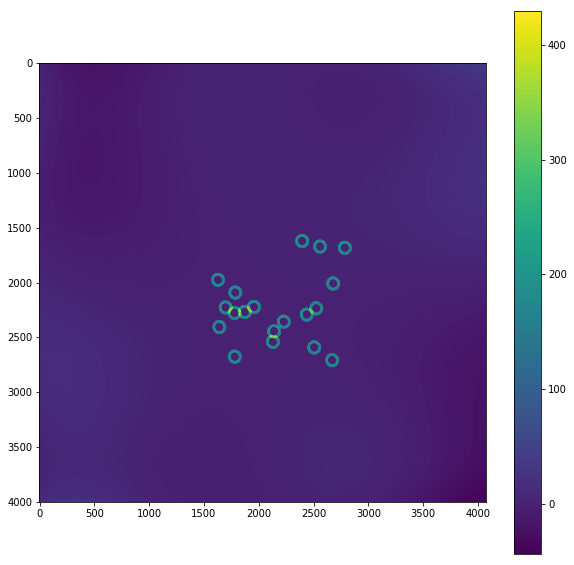

In [20]:
# Plot image array
fig = plt.figure(figsize=(10,10))
plt.imshow(raw.image.array)
plt.colorbar()

## Run minimal detection to get locations of possible sources

Try to find donuts by finding footprints and then keeping only the largest footprints.

**Note**: This section is based off of Imran Hasan's [SourceDetection/Footprints.ipynb](https://nbviewer.jupyter.org/github/LSSTScienceCollaborations/StackClub/blob/rendered/SourceDetection/Footprints.nbconvert.ipynb) notebook for the LSST Stack Club

**Can replace this part with alternative donut finding algorithm.**

In [21]:
# set up minimal detection task
schema = afwTable.SourceTable.makeMinimalSchema()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 20   # detection threshold in units of thresholdType
config.thresholdType = "value"#"stdev"   # units for thresholdValue

sourceDetectionTask = SourceDetectionTask(config=config)

In [22]:
footprint_set = sourceDetectionTask.detectFootprints(raw, sigma=1.)

In [23]:
f_set_pos = footprint_set.positive

In [24]:
f_prints = f_set_pos.getFootprints()

In [25]:
fp_areas = [fp.getArea() for fp in f_prints]

In [26]:
fp_large = np.where((np.array(fp_areas) > 10000.) & (np.array(fp_areas) < 100000.))[0]

In [12]:
f_prints_large = [f_prints[fp_idx] for fp_idx in fp_large]

In [13]:
source_centroids = [fp.getCentroid() for fp in f_prints_large]

In [14]:
source_centroids

[Point2D(2397.37193, 1622.218684),
 Point2D(2560.288182, 1672.302209),
 Point2D(2786.44653, 1683.498026),
 Point2D(1630.853719, 1976.086711),
 Point2D(2680.378731, 2009.08035),
 Point2D(1788.255209, 2091.740659),
 Point2D(1828.771916, 2247.686315),
 Point2D(2482.617629, 2263.972643),
 Point2D(1642.719704, 2405.799877),
 Point2D(2169.534485, 2444.365125),
 Point2D(2507.248099, 2591.659967),
 Point2D(1783.432103, 2675.121066),
 Point2D(2670.366757, 2707.753865)]

** Use WCS to translate centroid pixel positions into ra, dec **

In [15]:
from astropy.wcs import WCS
# Fixing issue in PhoSim output WCS

In [16]:
w = WCS(naxis=2)
w.wcs.crpix = [6225., 6261.]
w.wcs.cdelt = np.array([5.55555555555556E-05, 5.55555555555556E-05])
w.wcs.ctype = ['RA---TAN', 'DEC--TAN']

In [17]:
w.wcs_pix2world([[2397.333383, 1622.157387]], 1)

array([[ 3.59787353e+02, -2.57709966e-01]])

In [18]:
source_sky_pos = [w.wcs_pix2world([[source_centroid[1], source_centroid[0]]], 1) for source_centroid in source_centroids]

In [19]:
source_sky_pos

[array([[ 3.59744292e+02, -2.14642862e-01]]),
 array([[ 3.59747074e+02, -2.05592215e-01]]),
 array([[ 3.59747696e+02, -1.93028146e-01]]),
 array([[ 3.59763951e+02, -2.57226438e-01]]),
 array([[ 3.59765784e+02, -1.98920943e-01]]),
 array([[ 3.59770376e+02, -2.48482268e-01]]),
 array([[ 3.59779039e+02, -2.46231547e-01]]),
 array([[ 3.59779944e+02, -2.09907644e-01]]),
 array([[ 3.59787823e+02, -2.56567653e-01]]),
 array([[ 3.59789966e+02, -2.27300920e-01]]),
 array([[ 3.59798149e+02, -2.08539557e-01]]),
 array([[ 3.59802785e+02, -2.48750736e-01]]),
 array([[ 3.59804598e+02, -1.99477659e-01]])]

** Show our detected sources **

In [20]:
# we will make all the footprins heavy at the same time by operating on the footprint set
f_set_pos.makeHeavy(raw.getMaskedImage())
# we have to redefine fps
hfps = f_set_pos.getFootprints() 
hfps = [hfps[fp_idx] for fp_idx in fp_large]

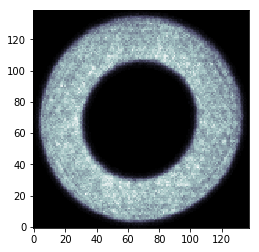

In [21]:
plt.imshow(f_prints_large[0].getSpans().unflatten(hfps[0].getImageArray()),
           cmap='bone', origin='lower')

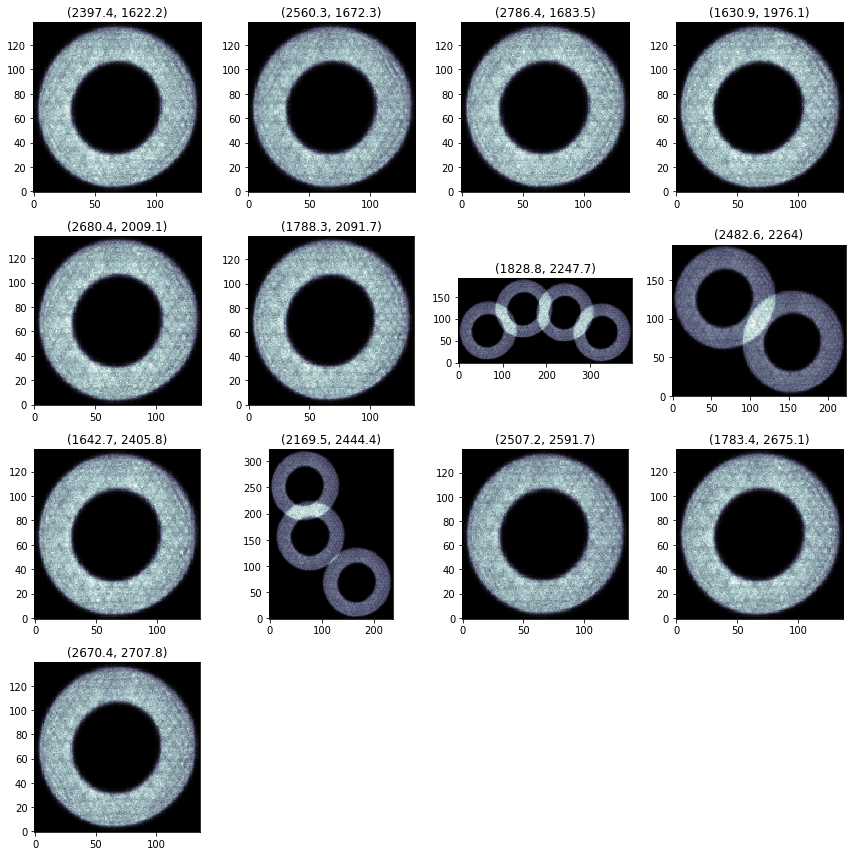

In [22]:
fig = plt.figure(figsize=(12,12))
for idx in range(len(f_prints_large)):
    fig.add_subplot(4, 4, idx+1)
    plt.imshow(f_prints_large[idx].getSpans().unflatten(hfps[idx].getImageArray()),
               cmap='bone', origin='lower')
    plt.title(source_centroids[idx])
plt.tight_layout()

## Match sources to catalog

Here we use `astropy` to match the centroids we have detected to a star catalog (in this case our phosim input catalog.)

In [23]:
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy.coordinates import SkyCoord

** Load star catalog **

In [24]:
source_cat_loc = os.path.join(data_dir, 'starCatDonutsEimg.txt')

In [25]:
source_cat = np.genfromtxt(source_cat_loc, names=True)

In [26]:
source_cat

array([( 0., 359.797559, -0.208609, 15.57),
       ( 1., 359.765147, -0.198973, 15.57),
       ( 2., 359.777309, -0.253506, 15.57),
       ( 3., 359.80401 , -0.199532, 15.57),
       ( 4., 359.789411, -0.228969, 15.57),
       ( 5., 359.794714, -0.229565, 15.57),
       ( 6., 359.747039, -0.193072, 15.57),
       ( 7., 359.802199, -0.248872, 15.57),
       ( 8., 359.780907, -0.212409, 15.57),
       ( 9., 359.78007 , -0.248992, 15.57),
       (10., 359.746419, -0.205648, 15.57),
       (11., 359.763312, -0.257357, 15.57),
       (12., 359.784484, -0.224041, 15.57),
       (13., 359.769748, -0.2486  , 15.57),
       (14., 359.777066, -0.239139, 15.57),
       (15., 359.787214, -0.256696, 15.57),
       (16., 359.779593, -0.243795, 15.57),
       (17., 359.743629, -0.214711, 15.57),
       (18., 359.777753, -0.207541, 15.57)],
      dtype=[('Id', '<f8'), ('Ra', '<f8'), ('Decl', '<f8'), ('Mag', '<f8')])

** Gather detected sources into an astropy catalog **

In [27]:
detected_ra = [src[0][0]*u.deg for src in source_sky_pos]
detected_dec = [src[0][1]*u.deg for src in source_sky_pos]

In [28]:
detected_cat = SkyCoord(ra=detected_ra, dec=detected_dec)

In [29]:
detected_cat

<SkyCoord (ICRS): (ra, dec) in deg
    [(359.74429162, -0.21464286), (359.74707399, -0.20559222),
     (359.74769597, -0.19302815), (359.7639506 , -0.25722644),
     (359.76578355, -0.19892094), (359.77037571, -0.24848227),
     (359.77903922, -0.24623155), (359.77994401, -0.20990764),
     (359.78782319, -0.25656765), (359.78996567, -0.22730092),
     (359.79814861, -0.20853956), (359.80278528, -0.24875074),
     (359.80459819, -0.19947766)]>

In [30]:
sky_cat = SkyCoord(ra=source_cat['Ra']*u.degree, dec=source_cat['Decl']*u.degree)

** Match each detected source to the nearest member of the star catalog **

In [31]:
det_src_idx = []
det_sep = []
for det_src in detected_cat:
    idx, d2d, d3d = det_src.match_to_catalog_sky(sky_cat)
    det_src_idx.append(idx)
    det_sep.append(d2d)

In [32]:
det_src_idx

[array(17),
 array(10),
 array(6),
 array(11),
 array(1),
 array(13),
 array(16),
 array(8),
 array(15),
 array(4),
 array(0),
 array(7),
 array(3)]

(17., 359.743629, -0.214711, 15.57) [0d00m02.398s]
(10., 359.746419, -0.205648, 15.57) [0d00m02.3665s]
(6., 359.747039, -0.193072, 15.57) [0d00m02.3703s]
(11., 359.763312, -0.257357, 15.57) [0d00m02.3465s]
(1., 359.765147, -0.198973, 15.57) [0d00m02.2992s]
(13., 359.769748, -0.2486, 15.57) [0d00m02.2991s]
(16., 359.779593, -0.243795, 15.57) [0d00m08.9953s]
(8., 359.780907, -0.212409, 15.57) [0d00m09.6492s]
(15., 359.787214, -0.256696, 15.57) [0d00m02.2412s]
(4., 359.789411, -0.228969, 15.57) [0d00m06.3284s]
(0., 359.797559, -0.208609, 15.57) [0d00m02.1373s]
(7., 359.802199, -0.248872, 15.57) [0d00m02.1553s]
(3., 359.80401, -0.199532, 15.57) [0d00m02.1265s]


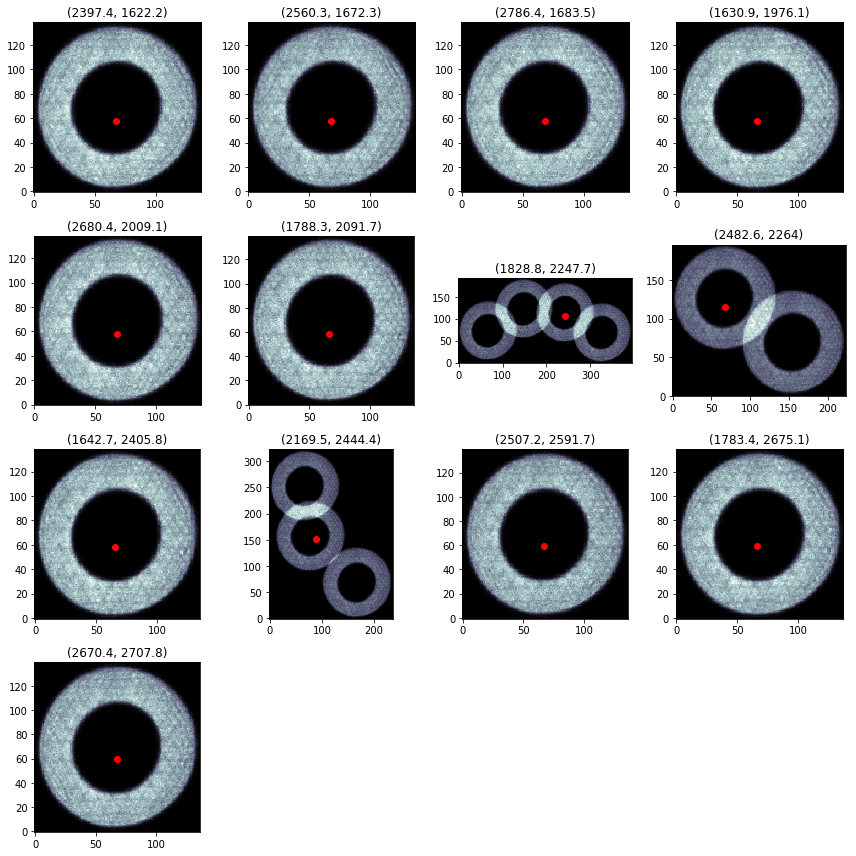

In [33]:
fig = plt.figure(figsize=(12,12))
total_star_pos = []
for idx in range(len(f_prints_large)):
    fig.add_subplot(4, 4, idx+1)
    fp_array = f_prints_large[idx].getSpans().unflatten(hfps[idx].getImageArray())
    plt.imshow(fp_array,
               cmap='bone', origin='lower')
    plt.title(source_centroids[idx])
    star_pos = w.wcs_world2pix([[source_cat[det_src_idx[idx]]['Ra'], source_cat[det_src_idx[idx]]['Decl']]], 1)
    print(source_cat[det_src_idx[idx]], det_sep[idx])
    plt.scatter(star_pos[0][1]-source_centroids[idx][0] + np.shape(fp_array)[1]/2, 
                star_pos[0][0]-source_centroids[idx][1] + np.shape(fp_array)[0]/2, c='r')
    total_star_pos.append(star_pos[0])
plt.tight_layout()

total_star_pos = np.array(total_star_pos)

**Compare positions**

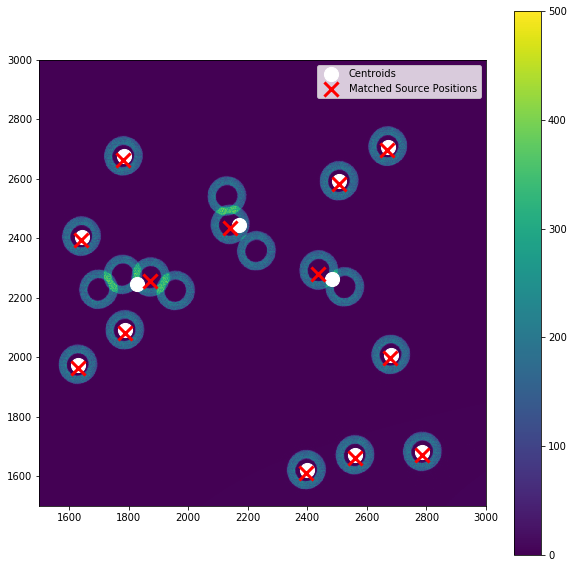

In [34]:
fig = plt.figure(figsize=(10,10))
plt.imshow(raw.image.array, vmax=500, vmin=0)
plt.colorbar()
plt.scatter(np.array(source_centroids)[:,0], np.array(source_centroids)[:,1], s=200, c='white', label='Centroids')
plt.scatter(total_star_pos[:, 1], total_star_pos[:, 0], c='r', marker='x', s=200, label='Matched Source Positions', lw=3)
plt.xlim(1500, 3000)
plt.ylim(1500, 3000)
plt.legend()

In [35]:
star_pos = w.wcs_world2pix(np.array([source_cat['Ra'], source_cat['Decl']]).T, 1)

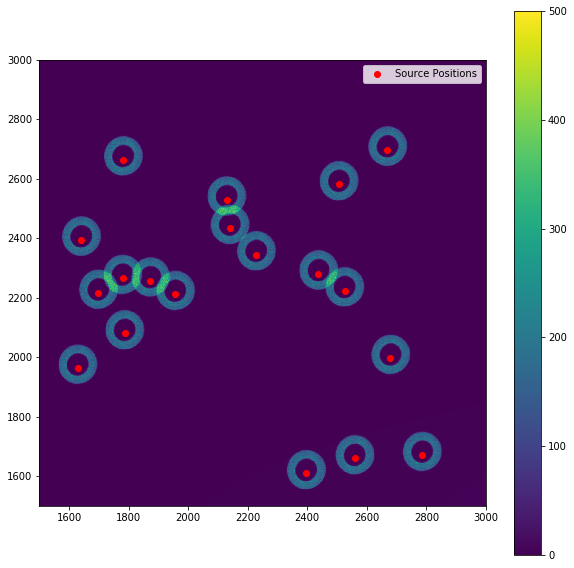

In [36]:
fig = plt.figure(figsize=(10,10))
plt.imshow(raw.image.array, vmax=500, vmin=0)
plt.colorbar()
plt.scatter(star_pos[:, 1], star_pos[:, 0], c='r', label='Source Positions')
plt.xlim(1500, 3000)
plt.ylim(1500, 3000)
plt.legend()